# Import helper_functions 

In [1]:
from helper_functions import (split_X_y, split_num_cat, forecasting_result, show_scores, APE, plot_histogram, 
                              fill_na_inf, calculating_kWh, plot_kWh, loss_acc_epochs, plot_pv, 
                              model_checkpoint, early_stop)

2024-02-20 20:58:21.041846: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-02-20 20:58:22.574594: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:7672] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-20 20:58:22.586422: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-20 20:58:22.586437: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1520] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-20 20:58:23.386521: I tensorflow/core/platform/cpu_feature_g

# Import historical dataset

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

original_df = pd.read_csv('../Data/hist_data.csv', 
                 index_col='timestamp_local', encoding='utf-8-sig', parse_dates=['timestamp_local'])

original_df.shape

(128832, 26)

In [3]:
'''
====================================
The imported dataset is already passed two preprocessing steps 

1. Remove timesteps with zero PV power output during daytime
2. Add sun position angles
====================================
'''
original_df.head(2)

,precip_rate,rh,wind_spd,timestamp_utc,snow_rate,app_temp,pres,azimuth,dewpt,uv,...,vis,dni,temp,slp,clouds,ts,PV_Power,declination_angle,altitude_angle,azimuth_angle
timestamp_local,,,,,,,,,,,,,,,,,,,,,
2016-01-04 00:00:00,0.0,61.0,1.6,2016-01-03 17:00:00,0.0,28.2,1014.76575,209.44,18.8,0.0,...,10.0,0.0,27.0,1015.0,25.0,1.451840e+09,0.0,-0.39703,-1.41642,0.00000
2016-01-04 00:15:00,0.0,63.0,1.6,2016-01-03 17:15:00,0.0,28.3,1014.76570,191.08,19.4,0.0,...,10.0,0.0,27.0,1015.0,25.0,1.451841e+09,0.0,-0.39703,-1.40442,0.37278


# Preprocessing data

## 1. Filter daytime timestamp

### 1.1 Advance filter

In [4]:
import datetime
hours = original_df.index.time
advance_filter = ((hours == datetime.time(0,0)) | (hours == datetime.time(1,0)) | (hours == datetime.time(2,0)) | 
                  (hours == datetime.time(3,0)) | (hours == datetime.time(4,0)) | (hours == datetime.time(5,0)) |
                  (hours >= datetime.time(6,0)) & (hours <= datetime.time(18,0)) | (hours == datetime.time(19,0)) | 
                  (hours == datetime.time(20,0)) | (hours == datetime.time(21,0)) |(hours == datetime.time(22,0)) |
                  (hours == datetime.time(23,0)))
len(advance_filter)

128832

In [5]:
adv_fil_df = original_df[advance_filter]
adv_fil_df.shape

(80520, 26)

### 1.2 Standard filter

In [6]:
import datetime
std_fil_df = original_df[(original_df.index.time >= datetime.time(6,0)) & (original_df.index.time <= datetime.time(18,0))]
std_fil_df.shape

(65758, 26)

In [7]:
# adv_fil_df.loc["2016-04-04":"2016-04-06"]['PV_Power'].plot();

In [8]:
print(f'Advance filter has {adv_fil_df.shape[0]} samples, presenting {(adv_fil_df.shape[0] * 100 / original_df.shape[0]):.2f} % from original df')
print(f'Standard filter has {std_fil_df.shape[0]} samples, presenting {(std_fil_df.shape[0] * 100 / original_df.shape[0]):.2f} % from original df \n')

print(f'Advance filter df => {adv_fil_df.loc["2016-01-04"].shape[0]} samples per day')
print(f'Standard filter df => {std_fil_df.loc["2016-01-04"].shape[0]} samples per day')


'''
Choose which filter dfs.
'''
# df = adv_fil_df
df = std_fil_df

Advance filter has 80520 samples, presenting 62.50 % from original df
Standard filter has 65758 samples, presenting 51.04 % from original df 

Advance filter df => 60 samples per day
Standard filter df => 49 samples per day


## 2. Features selections and arrange columns to extract spatial features 

In [9]:
'''
Arrange correlated columns:

`Irradiance` => `Temperatures` => `visibility` => 'Wind & humidity' => 'Sun Position' => 'PV_Power (y)' => Unused columns

'''
arr_cols = ['solar_rad', 'ghi', 'dhi', 'dni', 'uv', 'rh',       
            'app_temp', 'temp', 'dewpt', 
            'clouds', 'vis',             
            'wind_spd', 'wind_dir', 
            'declination_angle', 'altitude_angle', 'azimuth_angle',
            'PV_Power',
            'weather', 'precip_rate',   'timestamp_utc', 'snow_rate', 'pres', 'azimuth', 'elev_angle', 'slp', 'ts']

df = df[arr_cols]
df.columns

Index(['solar_rad', 'ghi', 'dhi', 'dni', 'uv', 'rh', 'app_temp', 'temp',
       'dewpt', 'clouds', 'vis', 'wind_spd', 'wind_dir', 'declination_angle',
       'altitude_angle', 'azimuth_angle', 'PV_Power', 'weather', 'precip_rate',
       'timestamp_utc', 'snow_rate', 'pres', 'azimuth', 'elev_angle', 'slp',
       'ts'],
      dtype='object')

In [10]:
# Split X columns into categorical and numerical 
categorical_columns, numerical_columns = split_num_cat(df)
print(f'Categorical columns : {categorical_columns} \n')
print(f'Numerical columns : {numerical_columns}')

Categorical columns : ['weather', 'timestamp_utc'] 

Numerical columns : ['solar_rad', 'ghi', 'dhi', 'dni', 'uv', 'rh', 'app_temp', 'temp', 'dewpt', 'clouds', 'vis', 'wind_spd', 'wind_dir', 'declination_angle', 'altitude_angle', 'azimuth_angle', 'PV_Power', 'precip_rate', 'snow_rate', 'pres', 'azimuth', 'elev_angle', 'slp', 'ts']


In [11]:
'''
Selecte columns which will not be passed to forecasting models
'''
y_col = ['PV_Power']

ignored_cols = ['dewpt', 'clouds', 'vis', 'precip_rate', 'azimuth', 'elev_angle', 
                'snow_rate', 'ts', 'pres', 'wind_dir', 'slp'] + categorical_columns 
print(f'Ignored columns : {ignored_cols}')

Ignored columns : ['dewpt', 'clouds', 'vis', 'precip_rate', 'azimuth', 'elev_angle', 'snow_rate', 'ts', 'pres', 'wind_dir', 'slp', 'weather', 'timestamp_utc']


In [12]:
# Split datasets by time
training_set = df.sort_index().loc[:'2018-09'] # Training set (2 years and 9 months) = 68%
val_set = df.sort_index().loc['2018-10':'2018-12'] # Validation set (3 months) = 7%
test_set = df.sort_index().loc['2019':] # Test set (1 year) = 25%

# Split `X` and `y`
X_train, y_train = split_X_y(training_set, ignored_cols)
X_val, y_val = split_X_y(val_set, ignored_cols)
X_test, y_test = split_X_y(test_set, ignored_cols)


X_cols = X_train.columns
print(f'List of X columns: \n{list(X_cols)} \n')
print(f'Total of X columns: \n{len(X_cols)}')

List of X columns: 
['solar_rad', 'ghi', 'dhi', 'dni', 'uv', 'rh', 'app_temp', 'temp', 'wind_spd', 'declination_angle', 'altitude_angle', 'azimuth_angle'] 

Total of X columns: 
12


In [13]:
## Time peroid of each dataset. 
print(
    f'''
    Training set is from {X_train.index.min()} to {X_train.index.max()} 
    Validation set is from {X_val.index.min()} to {X_val.index.max()} 
    Test set is from {X_test.index.min()} to {X_test.index.max()}
    ''')


    Training set is from 2016-01-04 06:00:00 to 2018-09-30 18:00:00 
    Validation set is from 2018-10-01 06:00:00 to 2018-12-31 18:00:00 
    Test set is from 2019-01-01 06:00:00 to 2019-12-31 18:00:00
    


## 3. Rescale numerical columns

In [14]:
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MaxAbsScaler

# Manage columns for Standardize processes
non_std_cols = ['declination_angle', 'altitude_angle', 'azimuth_angle']

selected_cols = list(map(lambda x : x not in non_std_cols, X_cols))
std_cols = X_cols[selected_cols]
print(f'Total of columns to rescale: \n{len(std_cols)}')
print(f'Columns to rescale are: {list(std_cols)} \n')

ct = make_column_transformer((MaxAbsScaler(), std_cols), remainder='passthrough')

ct.fit(X_train)

std_X_train = ct.transform(X_train)
std_X_val = ct.transform(X_val)
std_X_test = ct.transform(X_test)

std_X_train.shape, y_train.shape, std_X_val.shape, y_val.shape, std_X_test.shape, y_test.shape

Total of columns to rescale: 
9
Columns to rescale are: ['solar_rad', 'ghi', 'dhi', 'dni', 'uv', 'rh', 'app_temp', 'temp', 'wind_spd'] 



((44982, 12), (44982,), (4312, 12), (4312,), (16464, 12), (16464,))

In [15]:
'''
Check data type of all dataset
'''
std_X_train.dtype, y_train.dtype, std_X_val.dtype, y_val.dtype, std_X_test.dtype, y_test.dtype

(dtype('float32'),
 dtype('float32'),
 dtype('float32'),
 dtype('float32'),
 dtype('float32'),
 dtype('float32'))

In [16]:
print(f"training set = {np.round(std_X_train.shape[0] / df.shape[0], 2)}")
print(f"validation set = {np.round(std_X_val.shape[0] / df.shape[0], 2)}")
print(f"test set = {np.round(std_X_test.shape[0] / df.shape[0], 2)}")
print(f'total datapoints = {std_X_train.shape[0] + std_X_val.shape[0] + std_X_test.shape[0]}')

training set = 0.68
validation set = 0.07
test set = 0.25
total datapoints = 65758


In [17]:
'''
Testing normalize process
'''
print(f'Total samples in a day = {df.loc["2016-01-04"].shape[0]}')

Total samples in a day = 49


In [18]:
# pd.DataFrame(std_X_train).iloc[:147, 1].plot();

# Setup environment and sequence data
## 1. Check CPU and GPU available

In [19]:
import tensorflow as tf
from tensorflow import keras
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print("Tensorflow version = " + tf.__version__)

Num GPUs Available:  1
Tensorflow version = 2.14.0-dev20230509


## 2. Set random seed and state

In [20]:
import os, random
import tensorflow as tf

def set_seed(seed_value=20):
    random.seed(seed_value)
    np.random.seed(seed_value)
    tf.random.set_seed(seed_value)
    os.environ['PYTHONHASHSEED'] = str(seed_value)

## 4. Sequence data (Multivariate) 

In [21]:
'''
Historical data is recorded every 15 minutes (15 mins/sample). 
'''
sequence_size = 5
forecast_ahead = 10

window_size = df.loc["2016-01-04"].shape[0] * sequence_size
forecast_range = df.loc["2016-01-04"].shape[0] * (forecast_ahead-1)

def sequenceData(Input, Output, window_size, forecast_range):
    X, y = [], []
    for i in range(len(Input) - window_size - forecast_range):
        seq = i + window_size
        X.append(Input[i:seq])
        y.append(Output[seq + forecast_range])        
    return np.array(X), np.array(y)

seq_X_train, seq_y_train = sequenceData(std_X_train, y_train, window_size, forecast_range)
seq_X_val, seq_y_val = sequenceData(std_X_val, y_val, window_size, forecast_range)
seq_X_test, seq_y_test = sequenceData(std_X_test, y_test, window_size, forecast_range)

### Verify the sequence data

* Between `2016-05-01` to `2016-05-30`, there are:  
[ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]
(No date 18 and 19)
'''

In [22]:
# sequence_size = 2
# forecast_ahead = 2

# window_size = df.loc["2016-01-04"].shape[0] * sequence_size
# forecast_range = df.loc["2016-01-04"].shape[0] * (forecast_ahead-1)

# XX, yy = sequenceData(X_train.loc['2016-05-01':'2016-05-30'].index, 
#                       y_train.loc['2016-05-01':'2016-05-30'].index, window_size, forecast_range)

# yy[:10]

In [23]:
# XX.shape, XX[1]

----------------

In [24]:
print('======== Data Shape ======== \n'
    f'Training set: X = {seq_X_train.shape}, y = {seq_y_train.shape} \n'
     f'Validation set: X = {seq_X_val.shape}, y = {seq_y_val.shape} \n'
     f'Test set: X = {seq_X_test.shape}, y = {seq_y_test.shape} \n'
      f'Total samples in a day = {df.loc["2016-01-04"].shape[0]} \n'
     f'window size = {window_size}\n'
     f'forecast ahead = {forecast_ahead} days')

total_X_cols = len(X_cols)

======== Data Shape ======== 
Training set: X = (44296, 245, 12), y = (44296,) 
Validation set: X = (3626, 245, 12), y = (3626,) 
Test set: X = (15778, 245, 12), y = (15778,) 
Total samples in a day = 49 
window size = 245
forecast ahead = 10 days


# Building DL models

## 2. `LSTM`

In [25]:
from keras import Model
from keras.layers import Dense, LSTM, BatchNormalization, Dropout, Reshape, Input, Activation
from keras.optimizers import SGD, Adam
from keras.callbacks import ReduceLROnPlateau
from keras.metrics import RootMeanSquaredError

set_seed()
input_shape = seq_X_train.shape[1:]

# Structure model
inputs = Input(shape=input_shape, name='model_input')

x = LSTM(192, return_sequences=True, activation='tanh', dropout=0.1, name='1st_LSTM')(inputs)
x = LSTM(96, activation='tanh', dropout=0.1, name='2nd_LSTM')(x)
x = Dense(192, activation='relu', name='1st_dense')(x)
x = Dense(96, activation='relu', name='2nd_dense')(x)
x = Dense(48, activation='relu', name='3rd_dense')(x)
x = BatchNormalization()(x)
x = Dropout(0.1)(x)

output = Dense(1, activation='relu', name='model_output')(x)
LSTM_model = Model(inputs=inputs, outputs=output, name='LSTM_model')

# Configure optimizer
lr_scheduler = tf.keras.optimizers.schedules.InverseTimeDecay(0.001, decay_rate=1e-6, decay_steps=1, staircase=False)
opt = Adam(learning_rate=lr_scheduler)

# Define an optimizer and loss metric
LSTM_model.compile(optimizer=opt, loss='mean_absolute_error', metrics=['mean_absolute_error'])

LSTM_model.summary()

2024-02-20 20:59:21.444650: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 18211 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB MIG 3g.20gb, pci bus id: 0000:98:00.0, compute capability: 8.0


Model: "LSTM_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model_input (InputLayer)    [(None, 245, 12)]         0         
                                                                 
 1st_LSTM (LSTM)             (None, 245, 192)          157440    
                                                                 
 2nd_LSTM (LSTM)             (None, 96)                110976    
                                                                 
 1st_dense (Dense)           (None, 192)               18624     
                                                                 
 2nd_dense (Dense)           (None, 96)                18528     
                                                                 
 3rd_dense (Dense)           (None, 48)                4656      
                                                                 
 batch_normalization (Batch  (None, 48)                1

In [ ]:
set_seed()
'''
===================
Initial train model 
===================
'''
init_epochs = 15
Batch = 32

with tf.device('/GPU:0'):
    LSTM_history = LSTM_model.fit(x=seq_X_train, y=seq_y_train,
                                  epochs=init_epochs, batch_size=Batch,
                                  validation_data=(seq_X_val, seq_y_val), verbose=1)

Epoch 1/15


2024-02-20 21:00:28.341280: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:434] Loaded cuDNN version 8600
2024-02-20 21:00:31.409525: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2024-02-20 21:00:34.243381: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f6fcc515df0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-02-20 21:00:34.243538: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA A100-PCIE-40GB MIG 3g.20gb, Compute Capability 8.0
2024-02-20 21:00:35.962755: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-02-20 21:00:40.739462: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetim

1385/1385 [==============================] - 83s 36ms/step - loss: 2895.3770 - mean_absolute_error: 2895.3770 - val_loss: 2270.1335 - val_mean_absolute_error: 2270.1335
Epoch 2/15
1385/1385 [==============================] - 44s 30ms/step - loss: 2491.2715 - mean_absolute_error: 2491.2715 - val_loss: 1640.8348 - val_mean_absolute_error: 1640.8348
Epoch 3/15
1385/1385 [==============================] - 35s 24ms/step - loss: 1907.3088 - mean_absolute_error: 1907.3088 - val_loss: 1182.5052 - val_mean_absolute_error: 1182.5052
Epoch 4/15
1385/1385 [==============================] - 35s 24ms/step - loss: 1391.0632 - mean_absolute_error: 1391.0632 - val_loss: 994.2938 - val_mean_absolute_error: 994.2938
Epoch 5/15
1385/1385 [==============================] - 35s 24ms/step - loss: 1112.3440 - mean_absolute_error: 1112.3440 - val_loss: 878.0134 - val_mean_absolute_error: 878.0134
Epoch 6/15
1385/1385 [==============================] - 42s 29ms/step - loss: 1042.1870 - mean_absolute_error: 1042

In [ ]:
set_seed()

'''
=====================================
Train model with callbacks functions
=====================================
'''
# checkpoint_epochs = init_epochs + 20
# Batch = 32

# with tf.device('/GPU:0'):
#     LSTM_checkpoint_history = LSTM_model.fit(x=UniSeq_X_train, y=UniSeq_y_train,
#                                              epochs=checkpoint_epochs, initial_epoch=init_epochs,
#                                              batch_size=Batch, validation_data=(UniSeq_X_val, UniSeq_y_val),
#                                              verbose=1, callbacks=[early_stop('val_loss', 3), 
#                                                                  model_checkpoint('seq_LSTM')])

### Saved model


In [36]:
# Save the model
LSTM_model.save('saved_models/LSTM_model_paper_version')

# load the model
# LSTM_model = keras.models.load_model('saved_models/LSTM_model2')

## Forecast and evaluation results

### PV power forecasting

In [37]:
LSTM_val_result = forecasting_result(LSTM_model, seq_X_val)
LSTM_test_result = forecasting_result(LSTM_model, seq_X_test)

494/494 [==============================] - 5s 8ms/step


In [38]:
LSTM_val_scores = show_scores(LSTM_val_result, seq_y_val)

Mean Absolute Error = 816.38 W 
Root Mean Squared Error = 1250.55 W 
Mean Bias Error = 302.39 W 
 
Normalized_MAE (installed_Power) = 8.16% 
Normalized_RMSE (installed_Power) = 12.51% 
 
Normalized_MAE (avg_Power) = 32.91% 
Normalized_RMSE (avg_Power) = 50.41% 
 
Peak PV output power (from y_test) = 7647.67 W 
Average PV output power (from y_test) = 2480.68 W


In [40]:
LSTM_test_scores = show_scores(LSTM_test_result, seq_y_test)

Mean Absolute Error = 888.67 W 
Root Mean Squared Error = 1255.30 W 
Mean Bias Error = -6.13 W 
 
Normalized_MAE (installed_Power) = 8.89% 
Normalized_RMSE (installed_Power) = 12.55% 
 
Normalized_MAE (avg_Power) = 28.73% 
Normalized_RMSE (avg_Power) = 40.58% 
 
Peak PV output power (from y_test) = 9875.00 W 
Average PV output power (from y_test) = 3093.70 W


## Plot loss vs Epochs

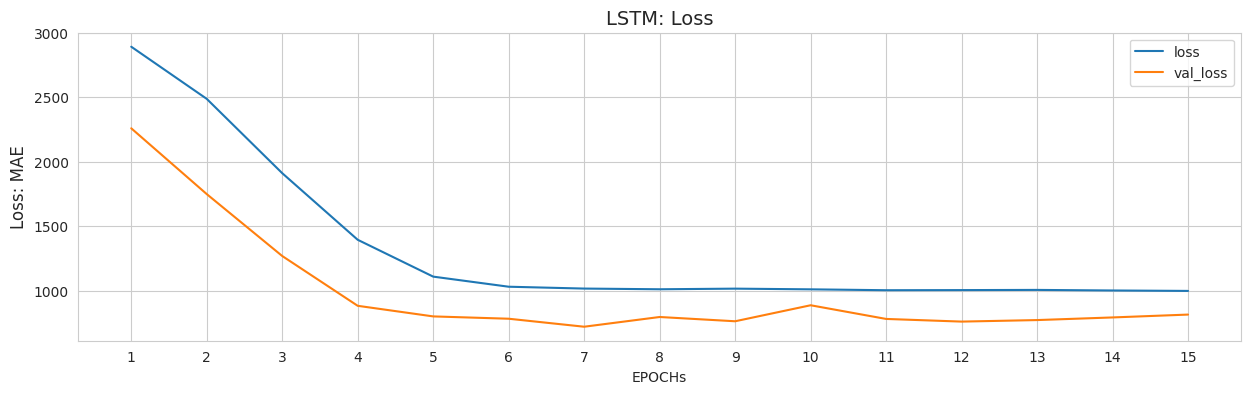

In [41]:
loss_acc_epochs(LSTM_history, 'LSTM', 'MAE')

In [42]:
# Save loss vs epoch
# pd.DataFrame(LSTM_history.history).to_csv('data_for_report/LSTM_loss_epoch (10 epochs - sun_position).csv')

In [43]:
# plot_pv(LSTM_val_result, y_val[(window_size + forecast_range):], 'LSTM', {'year':2018, 'month':11, 'start':22, 'end':25})

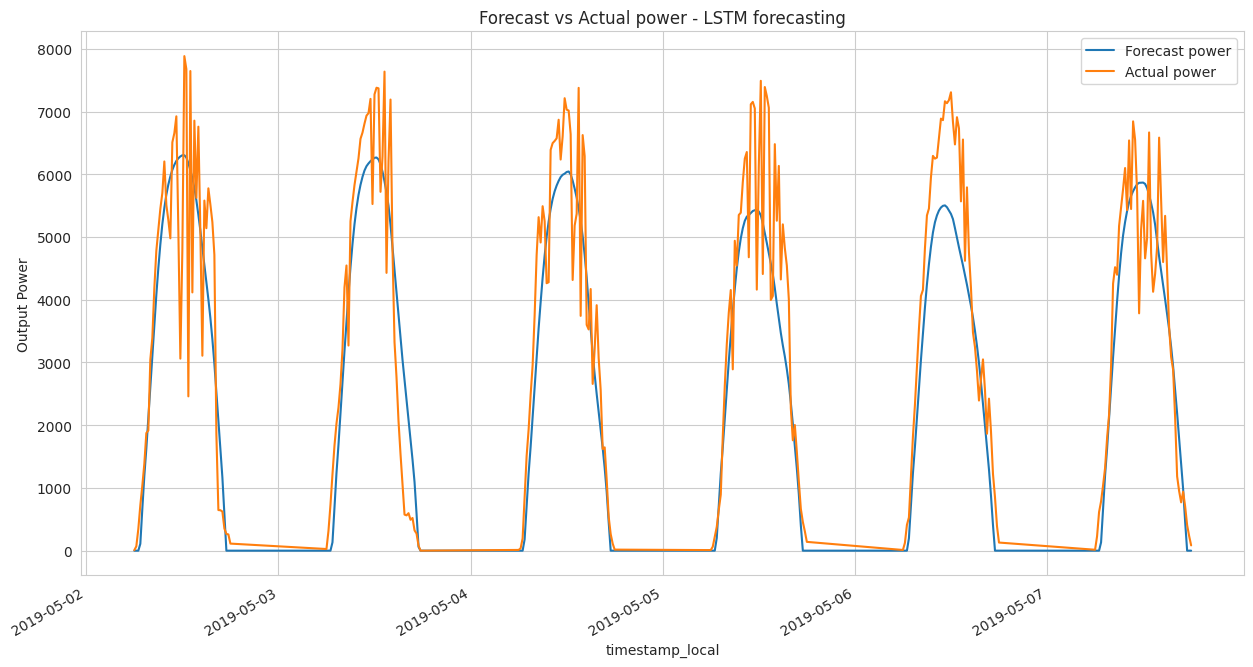

In [51]:
plot_pv(LSTM_test_result, y_test[(window_size + forecast_range):], 'LSTM', {'year':2019, 'month':5, 'start':3, 'end':8})

In [52]:
LSTM_test_result.max()

6405.7163

## 3. CNN + LSTM

In [25]:
print('======== Data Shape ======== \n'
    f'Training set: X = {seq_X_train.shape}, y = {seq_y_train.shape} \n'
     f'Validation set: X = {seq_X_val.shape}, y = {seq_y_val.shape} \n'
     f'Test set: X = {seq_X_test.shape}, y = {seq_y_test.shape} \n'
      f'Total samples in a day = {df.loc["2016-01-04"].shape[0]} \n'
     f'window size = {window_size}\n'
     f'forecast ahead = {forecast_ahead} days')

======== Data Shape ======== 
Training set: X = (44296, 245, 12), y = (44296,) 
Validation set: X = (3626, 245, 12), y = (3626,) 
Test set: X = (15778, 245, 12), y = (15778,) 
Total samples in a day = 49 
window size = 245
forecast ahead = 10 days


In [26]:
from keras import Model
from keras.layers import Dense, LSTM, BatchNormalization, Dropout, Conv1D, Reshape, Input, Activation, Conv2D
from keras.optimizers import SGD, Adam
from keras.callbacks import ReduceLROnPlateau
from keras.metrics import RootMeanSquaredError


set_seed()

# Structure model
inputs = Input(shape=(*seq_X_train.shape[1:], 1), name='model_input')

## Conv2D
x = Conv2D(32, kernel_size=(1, 3), strides=(1, 1), padding='valid', activation='relu', name='1st_Conv2D')(inputs)
x = Conv2D(1, kernel_size=(1, 3), strides=(1, 1), padding='valid', activation='relu', name='2nd_Conv2D')(x)
x = Reshape(target_shape=(x.shape[1:-1]))(x)
# print('shape before passing to LSTM layers = ', x.shape)

## LSTM and Dense
x = LSTM(96, return_sequences=True, activation='tanh', dropout=0.1, name='1st_LSTM')(x)
x = LSTM(48, activation='tanh', dropout=0.1, name='2nd_LSTM')(x)
x = Dense(64, activation='relu', name='1st_dense')(x)
x = Dense(32, activation='relu', name='2nd_dense')(x)
# x = Dense(48, activation='relu', name='3rd_dense')(x)
x = BatchNormalization()(x)
x = Dropout(0.1)(x)

# x = LSTM(96, return_sequences=True, activation='tanh', dropout=0.2, name='1st_LSTM')(x)
# x = LSTM(48, activation='tanh', dropout=0.1, name='2nd_LSTM')(x)
# x = Dense(96, activation='relu', name='1st_dense')(x)
# x = BatchNormalization()(x)
# x = Dropout(0.2)(x)
# x = Dense(48, activation='relu', name='2nd_dense')(x)
# x = BatchNormalization()(x)
# x = Dropout(0.1)(x)

output = Dense(1, activation='relu', name='model_output')(x)
CNNLSTM_model = Model(inputs=inputs, outputs=output, name='CNNLSTM_model')

# Configure optimizer
lr_scheduler = tf.keras.optimizers.schedules.InverseTimeDecay(0.001, decay_rate=1e-6, decay_steps=1, staircase=False)
opt = Adam(learning_rate=lr_scheduler)

# define an optimizer and loss measure
CNNLSTM_model.compile(optimizer=opt, loss='mean_absolute_error', metrics=['mean_absolute_error'])

CNNLSTM_model.summary()

2024-01-09 18:43:41.425393: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1071 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB MIG 3g.20gb, pci bus id: 0000:98:00.0, compute capability: 8.0


Model: "CNNLSTM_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model_input (InputLayer)    [(None, 245, 12, 1)]      0         
                                                                 
 1st_Conv2D (Conv2D)         (None, 245, 10, 32)       128       
                                                                 
 2nd_Conv2D (Conv2D)         (None, 245, 8, 1)         97        
                                                                 
 reshape (Reshape)           (None, 245, 8)            0         
                                                                 
 1st_LSTM (LSTM)             (None, 245, 96)           40320     
                                                                 
 2nd_LSTM (LSTM)             (None, 48)                27840     
                                                                 
 1st_dense (Dense)           (None, 64)              

In [27]:
set_seed()
'''
===================
Initial train model 
===================
'''
init_epochs = 20
Batch = 32

with tf.device('/GPU:0'):
    CNNLSTM_history = CNNLSTM_model.fit(x=seq_X_train, y=seq_y_train,
                                        epochs=init_epochs, batch_size=Batch,
                                        validation_data=(seq_X_val, seq_y_val), verbose=1)

Epoch 1/20


2024-01-09 18:45:12.075705: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:434] Loaded cuDNN version 8600
2024-01-09 18:45:27.163200: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2024-01-09 18:45:29.982482: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fee58035c50 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-01-09 18:45:29.983402: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA A100-PCIE-40GB MIG 3g.20gb, Compute Capability 8.0
2024-01-09 18:45:32.156829: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-01-09 18:45:38.656893: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetim

1385/1385 [==============================] - ETA: 0s - loss: 2916.9280 - mean_absolute_error: 2916.9280

2024-01-09 18:47:04.910906: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 557.70MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


1385/1385 [==============================] - 133s 45ms/step - loss: 2916.9280 - mean_absolute_error: 2916.9280 - val_loss: 2306.8772 - val_mean_absolute_error: 2306.8772
Epoch 2/20
1385/1385 [==============================] - 46s 30ms/step - loss: 2629.2419 - mean_absolute_error: 2629.2419 - val_loss: 1921.2405 - val_mean_absolute_error: 1921.2405
Epoch 3/20
1385/1385 [==============================] - 49s 34ms/step - loss: 2191.1294 - mean_absolute_error: 2191.1294 - val_loss: 1460.7965 - val_mean_absolute_error: 1460.7965
Epoch 4/20
1385/1385 [==============================] - 46s 32ms/step - loss: 1725.3895 - mean_absolute_error: 1725.3895 - val_loss: 1126.2216 - val_mean_absolute_error: 1126.2216
Epoch 5/20
1385/1385 [==============================] - 47s 32ms/step - loss: 1336.5168 - mean_absolute_error: 1336.5168 - val_loss: 816.9549 - val_mean_absolute_error: 816.9549
Epoch 6/20
1385/1385 [==============================] - 52s 36ms/step - loss: 1111.3864 - mean_absolute_error: 1

### Saved model


In [28]:
# Save the model
# CLSTM_model.save('saved_models/CLSTM_model3')

# load the model
# CLSTM_model = keras.models.load_model('saved_models/CLSTM_model2')

## Forecast and evaluation results

### PV power forecasting

In [29]:
CNNLSTM_val_result = forecasting_result(CNNLSTM_model, seq_X_val)
CNNLSTM_test_result = forecasting_result(CNNLSTM_model, seq_X_test)

494/494 [==============================] - 34s 62ms/step


In [30]:
CNNLSTM_val_scores = show_scores(CNNLSTM_val_result, seq_y_val)

Mean Absolute Error = 828.03 W 
Root Mean Squared Error = 1305.73 W 
Mean Bias Error = 563.23 W 
 
Normalized_MAE (installed_Power) = 8.28% 
Normalized_RMSE (installed_Power) = 13.06% 
 
Normalized_MAE (avg_Power) = 33.38% 
Normalized_RMSE (avg_Power) = 52.64% 
 
Peak PV output power (from y_test) = 7647.67 W 
Average PV output power (from y_test) = 2480.68 W


In [31]:
CNNLSTM_test_scores = show_scores(CNNLSTM_test_result, seq_y_test)

Mean Absolute Error = 856.13 W 
Root Mean Squared Error = 1230.02 W 
Mean Bias Error = 62.85 W 
 
Normalized_MAE (installed_Power) = 8.56% 
Normalized_RMSE (installed_Power) = 12.30% 
 
Normalized_MAE (avg_Power) = 27.67% 
Normalized_RMSE (avg_Power) = 39.76% 
 
Peak PV output power (from y_test) = 9875.00 W 
Average PV output power (from y_test) = 3093.70 W


## Plot loss vs Epochs

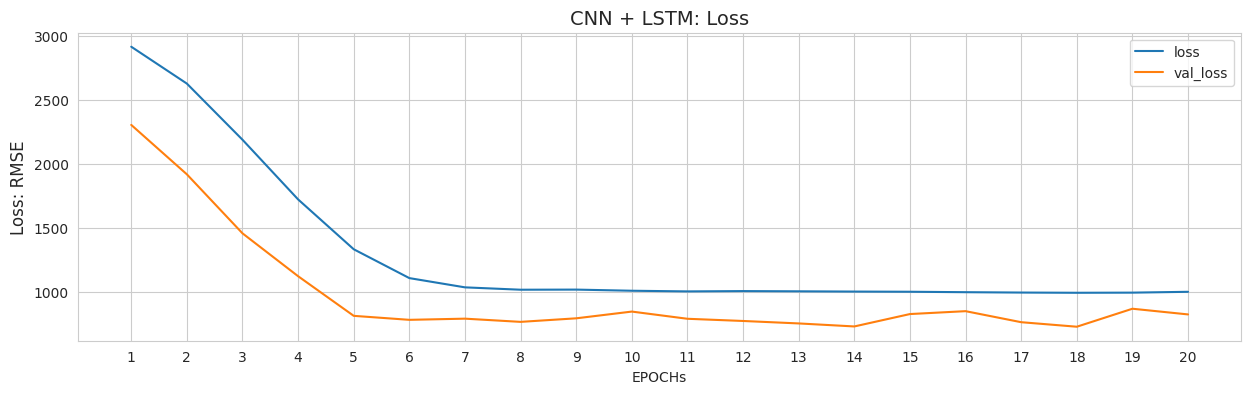

In [32]:
loss_acc_epochs(CNNLSTM_history, 'CNN + LSTM', 'RMSE')

In [77]:
# Save loss vs epoch
# pd.DataFrame(CLSTM_history.history).to_csv('data_for_report/CLSTM_loss_epoch (10 epochs - sun_position).csv')

In [78]:
# plot_pv(CNNLSTM_val_result, y_val[(window_size + forecast_range):], 'CNN + LSTM', {'year':2018, 'month':11, 'start':3, 'end':8})

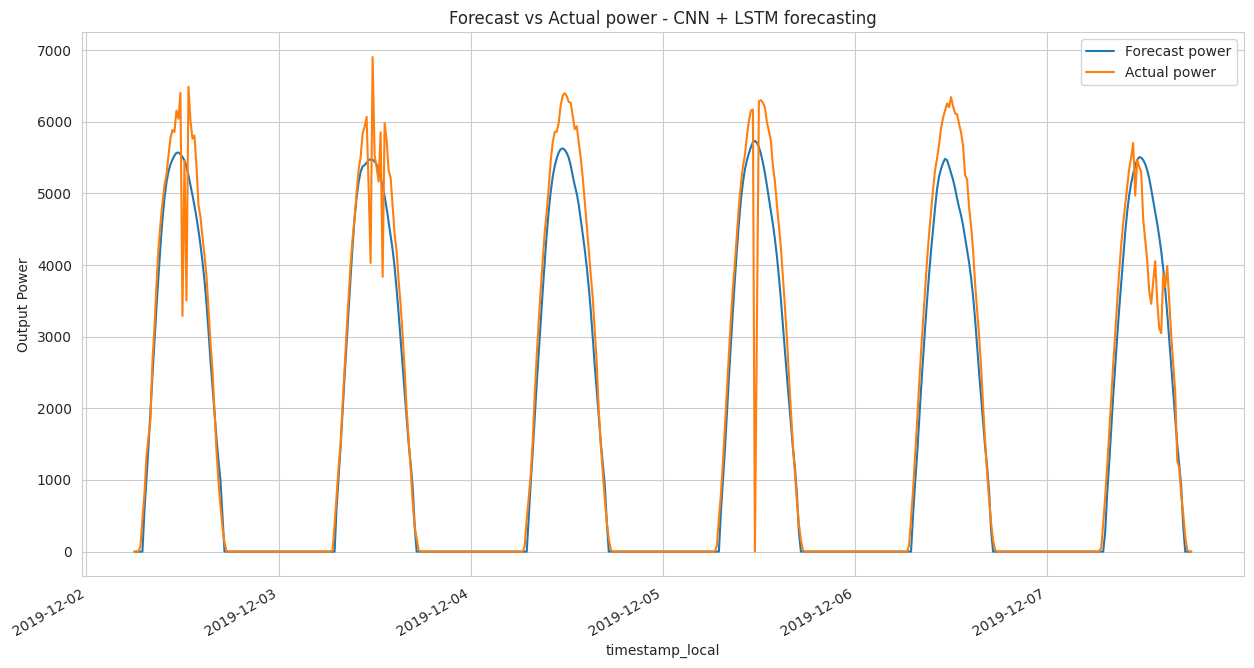

In [33]:
plot_pv(CNNLSTM_test_result, y_test[(window_size + forecast_range):], 'CNN + LSTM', {'year':2019, 'month':12, 'start':3, 'end':8})

In [34]:
CNNLSTM_test_result.max()

6276.3716

In [38]:
CLSTM_results_df = pd.concat([y_test[(window_size + forecast_range):].reset_index(),
                              pd.Series(CNNLSTM_test_result)], axis=1)

CLSTM_results_df.columns = ['timestamp', 'Actual', 'CNN+LSTM']
CLSTM_results_df = CLSTM_results_df.set_index('timestamp')
CLSTM_results_df.head(60)

,Actual,CNN+LSTM
timestamp,,
2019-01-19 06:00:00,0.000000,0.000000
2019-01-19 06:15:00,0.000000,0.000000
2019-01-19 06:30:00,0.000000,0.000000
2019-01-19 06:45:00,1.333333,0.000000
2019-01-19 07:00:00,11.000000,0.000000
2019-01-19 07:15:00,226.000000,0.000000
2019-01-19 07:30:00,461.666656,617.353760
2019-01-19 07:45:00,813.000000,1035.303101
2019-01-19 08:00:00,1033.666626,1368.810547


In [42]:
CLSTM_results_df['APE_CNNLSTM'] = APE(CLSTM_results_df['CNN+LSTM'], CLSTM_results_df['Actual'])
CLSTM_results_df = fill_na_inf(CLSTM_results_df)
CLSTM_results_df.isna().sum()

Actual         0
CNN+LSTM       0
APE_CNNLSTM    0
dtype: int64

143.89314
23.29
91693.88
0.0


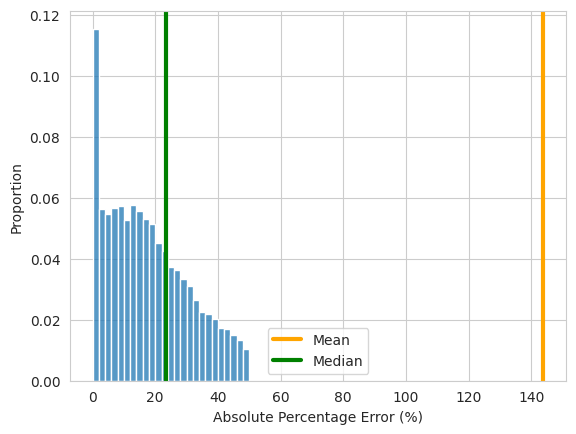

In [43]:
plot_histogram(CLSTM_results_df['APE_CNNLSTM'], 2, 50)
print(CLSTM_results_df['APE_CNNLSTM'].mean())
print(CLSTM_results_df['APE_CNNLSTM'].median())
print(CLSTM_results_df['APE_CNNLSTM'].max())
print(CLSTM_results_df['APE_CNNLSTM'].min())

In [50]:
CLSTM_results_df.query('APE_CNNLSTM >= 100')['APE_CNNLSTM']

timestamp
2019-01-19 06:45:00    100.000000
2019-01-19 07:00:00    100.000000
2019-01-19 07:15:00    100.000000
2019-01-19 09:00:00    136.610001
2019-01-19 09:15:00    105.470001
                          ...    
2019-12-31 08:45:00    100.019997
2019-12-31 12:45:00    104.589996
2019-12-31 15:00:00    192.800003
2019-12-31 17:30:00    100.000000
2019-12-31 17:45:00    100.000000
Name: APE_CNNLSTM, Length: 2759, dtype: float32

------------------------

## Compare results between LSTM and CNNLSTM (Present)

In [82]:
seq_models_scores = pd.DataFrame([LSTM_test_scores, CNNLSTM_test_scores], 
                                 index=['LSTM', 'CNN + LSTM']).round(2)
seq_models_scores

,MAE,RMSE,MBE,NMAE_installed,NRMSE_installed,NMAE_avg,NRMSE_avg
LSTM,888.669983,1255.300049,-6.13,8.89,12.55,28.73,40.58
CNN + LSTM,874.020020,1244.199951,6.55,8.74,12.44,28.25,40.22


In [86]:
'''
Testing set only has 336 days which make some sequences more than 5 days because the missing dates

The baseline NRMSEavg = 39% on both 1 day, 5 days, 10 days and 15 days forecast ahead
'''

# X_test.resample('D').size()[X_test.resample('D').size() > 0][:30]

'\nTesting set only has 336 days which make some sequences more than 5 days because the missing dates\n\nThe baseline NRMSEavg = 39% on both 1 day, 5 days, 10 days and 15 days forecast ahead\n'

------------------------------------

## Check APE

In [88]:
results_df = pd.concat([y_test[(window_size + forecast_range):].reset_index(),
                        pd.Series(LSTM_test_result), pd.Series(CNNLSTM_test_result)], axis=1)

results_df.columns = ['timestamp', 'Actual', 'LSTM', 'CNN+LSTM']
results_df = results_df.set_index('timestamp')
results_df.head(60)

,Actual,LSTM,CNN+LSTM
timestamp,,,
2019-01-19 06:00:00,0.000000,0.000000,0.000000
2019-01-19 06:15:00,0.000000,0.000000,0.000000
2019-01-19 06:30:00,0.000000,0.000000,0.000000
2019-01-19 06:45:00,1.333333,0.000000,0.000000
2019-01-19 07:00:00,11.000000,0.000000,0.000000
2019-01-19 07:15:00,226.000000,0.000000,155.705521
2019-01-19 07:30:00,461.666656,396.929779,671.167847
2019-01-19 07:45:00,813.000000,905.093384,1105.608765
2019-01-19 08:00:00,1033.666626,1365.544922,1534.789185


In [89]:
results_df['APE_LSTM'] = APE(results_df['LSTM'], results_df['Actual'])
results_df['APE_CNNLSTM'] = APE(results_df['CNN+LSTM'], results_df['Actual'])
results_df.shape

(15778, 5)

In [90]:
results_df = fill_na_inf(results_df)
results_df.head()

,Actual,LSTM,CNN+LSTM,APE_LSTM,APE_CNNLSTM
timestamp,,,,,
2019-01-19 06:00:00,0.000000,0.0,0.0,0.0,0.0
2019-01-19 06:15:00,0.000000,0.0,0.0,0.0,0.0
2019-01-19 06:30:00,0.000000,0.0,0.0,0.0,0.0
2019-01-19 06:45:00,1.333333,0.0,0.0,100.0,100.0
2019-01-19 07:00:00,11.000000,0.0,0.0,100.0,100.0


125.170044
26.07
85869.74
0.0


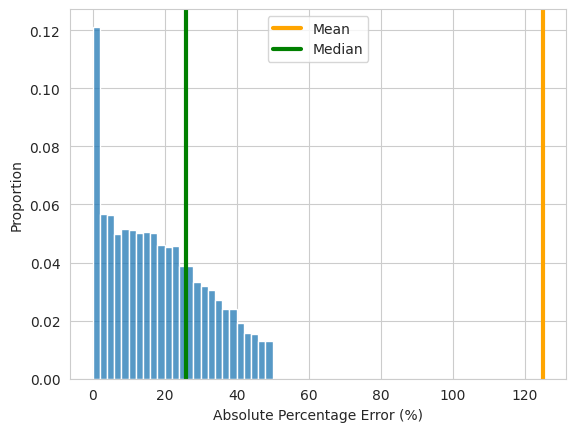

In [91]:
plot_histogram(results_df['APE_LSTM'], 2, 50)
print(results_df['APE_LSTM'].mean())
print(results_df['APE_LSTM'].median())
print(results_df['APE_LSTM'].max())
print(results_df['APE_LSTM'].min())

137.81575
24.275002
92718.01
0.0


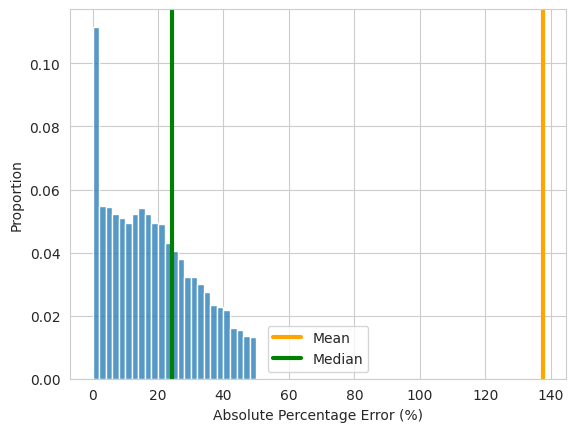

In [92]:
plot_histogram(results_df['APE_CNNLSTM'], 2, 50)
print(results_df['APE_CNNLSTM'].mean())
print(results_df['APE_CNNLSTM'].median())
print(results_df['APE_CNNLSTM'].max())
print(results_df['APE_CNNLSTM'].min())

In [95]:
results_df.to_csv('./data_for_report/LSTM_and_CNLS_results.csv')

----------------------------------
----------------------------------
----------------------------------
----------------------------------
----------------------------------